# Special cases with using FEDOT for time series. 
#### FEDOT version = 0.5

In [ ]:
pip install fedot==0.5

[Original repository on GitHub](https://github.com/nccr-itmo/FEDOT)

This tutorial was prepared by [Natural Systems Simulation Team](https://github.com/ITMO-NSS-team)

--- 

This notebook contains examples of using the advanced functionality of the FEDOT framework both for predicting time series and for filling in gaps in them.

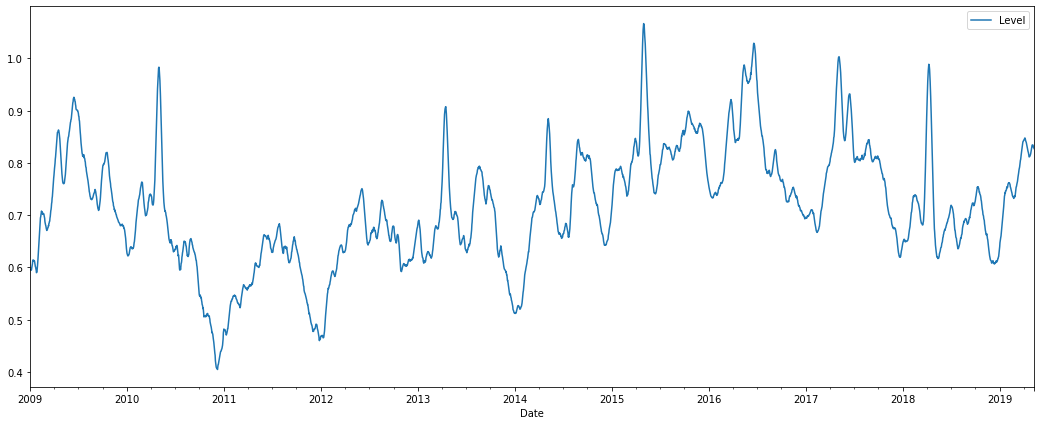

In [2]:
# Additional imports 
import pandas as pd 
import numpy as np

# Imports for creating plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

# Pipeline and nodes
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

# Data 
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum

# Tasks
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# Read the file
df = pd.read_csv('ts_sea_level.csv')
df['Date'] = pd.to_datetime(df['Date'])

df.plot('Date', 'Level')
plt.show()

We have a time series of sea level, which was obtained from the ["Daily sea level data in the grid of satellite observations"](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-global?tab=overview).

<img src="../jupyter_media/time_series/sea_map.png" width="800"/> 

Map of the location of points where sea surface height above the average surface of the geoid (the heatmap is presented for 01.01.2003) values were extracted. The point from which the time series was taken are shown in blue.

This time series can be used to obtain a forecast for several elements ahead. 

Below we will conduct 2 cases: 
* make a large forecast for several thousand values ahead;
* fill in the gaps in time series (we will generate these gaps in it beforehand).

In [3]:
# Let's prepare a function for visualizing forecasts
def plot_results(actual_time_series, predicted_values, len_train_data, y_name = 'Parameter'):
    """
    Function for drawing plot with predictions
    
    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """
    
    plt.plot(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = 'Predicted', c = 'blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c = 'black', linewidth = 1)
    plt.ylabel(y_name, fontsize = 15)
    plt.xlabel('Time index', fontsize = 15)
    plt.legend(fontsize = 15, loc='upper left')
    plt.grid()
    plt.show()

## Multistep (out-of-sample) time series forecasting

Imagine that we want to predict a given time series 200 elements ahead. Let's do it!

In [4]:
# Specify forecast length
forecast_length = 200

# Got univariate time series as numpy array
time_series = np.array(df['Level'])

# Wrapp data into InputData
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=forecast_length))
input_data = InputData(idx=np.arange(0, len(time_series)),
                       features=time_series,
                       target=time_series,
                       task=task,
                       data_type=DataTypesEnum.ts)

# Split data into train and test
train_input, predict_input = train_test_data_setup(input_data)

Now we will prepare a pipeline with which we will forecast the time series.

In [5]:
def get_pipeline():
    node_lagged_1 = PrimaryNode('lagged')
    node_lagged_1.custom_params = {'window_size': 120}
    node_lagged_2 = PrimaryNode('lagged')
    node_lagged_2.custom_params = {'window_size': 10}

    node_first = SecondaryNode('ridge', nodes_from=[node_lagged_1])
    node_second = SecondaryNode('dtreg', nodes_from=[node_lagged_2])
    node_final = SecondaryNode('ridge', nodes_from=[node_first, node_second])
    pipeline = Pipeline(node_final)

    return pipeline

pipeline = get_pipeline()

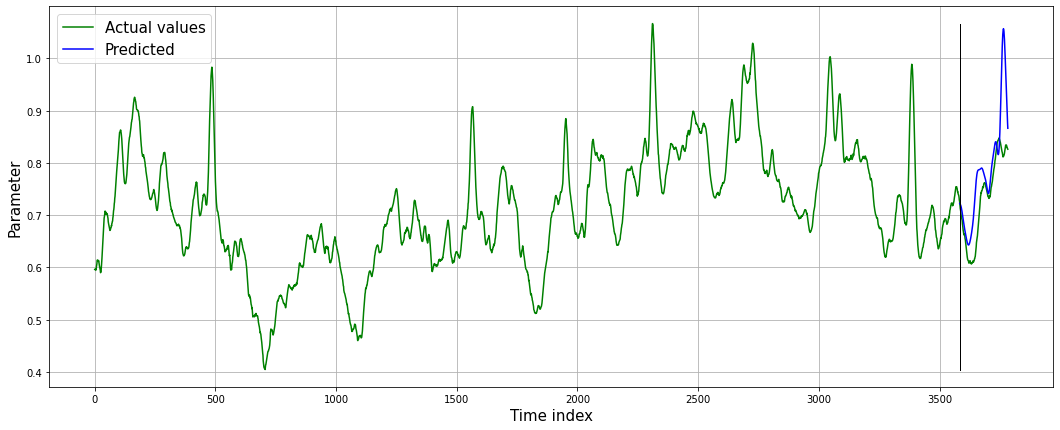

In [6]:
# Fit pipeline
pipeline.fit(train_input)

# Make forecast
output = pipeline.predict(predict_input)
forecast = np.ravel(np.array(output.predict))

# Plot the graph
plot_results(actual_time_series = time_series,
             predicted_values = forecast, 
             len_train_data = len(time_series)-forecast_length)

And now imagine that we need to give a forecast for 1000 elements ahead.

> How to do this? Our model is trained to make a forecast only 200 elements ahead, and we do not have time to wait for the new model train. 

You can use "out_of_sample_ts_forecast" function!

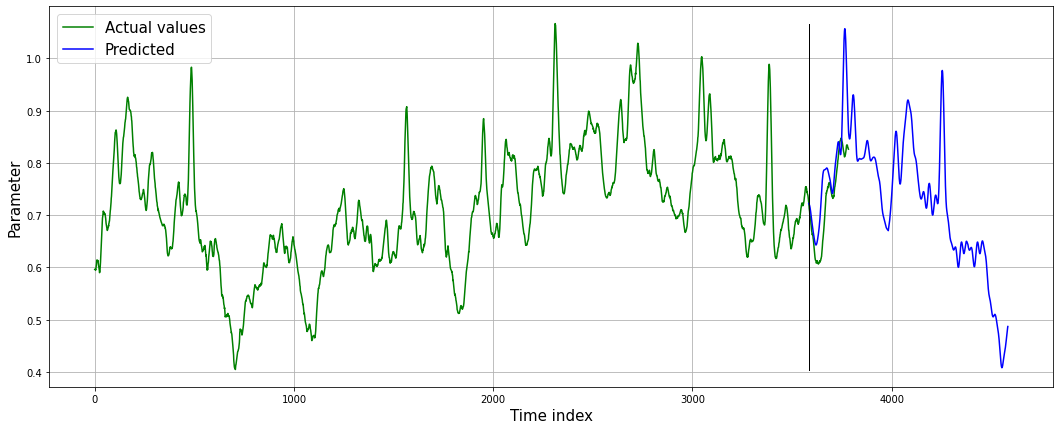

In [7]:
from fedot.core.pipelines.ts_wrappers import out_of_sample_ts_forecast

# Make forecast
ts_predicted = out_of_sample_ts_forecast(pipeline=pipeline,
                                         input_data=predict_input,
                                         horizon=1000)

# Plot the graph
plot_results(actual_time_series = time_series,
             predicted_values = ts_predicted, 
             len_train_data = len(time_series)-forecast_length)

> Perfect! But what if we want to give a forecast for 3153 elements? 

We can also do it!

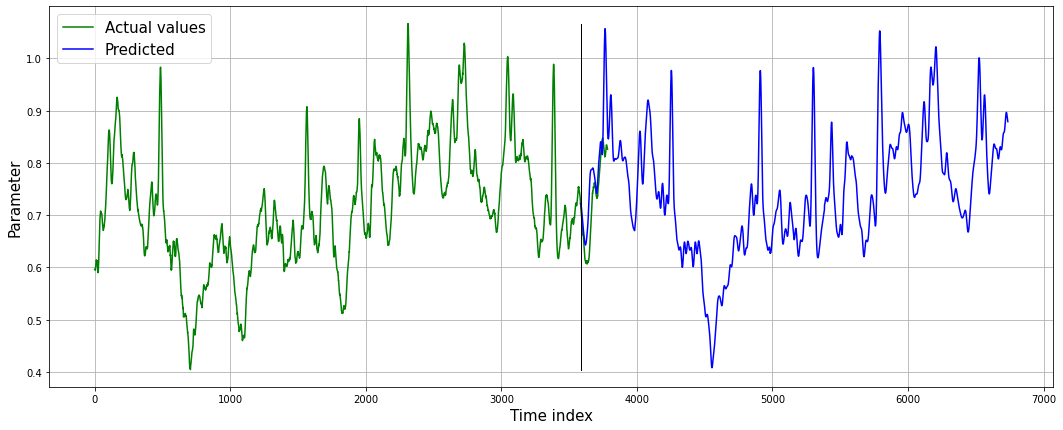

In [8]:
# Make forecast
ts_predicted = out_of_sample_ts_forecast(pipeline=pipeline,
                                         input_data=predict_input,
                                         horizon=3153)

# Plot the graph
plot_results(actual_time_series = time_series,
             predicted_values = ts_predicted, 
             len_train_data = len(time_series)-forecast_length)

This approach can also potentially be suitable for generating synthetic time series.

## Time series gap-filling

Time series can sometimes contain gaps which complicates processing. Let's imagine that our time series is exactly like this. To do this, we will generate omissions in it ourselves.

In [9]:
def generate_gaps_in_ts(array_without_gaps, gap_dict, gap_value):
    """
    Function for generating gaps with predefined length in the desired indices
    of an one-dimensional array (time series)

    :param array_without_gaps: an array without gaps
    :param gap_dict: a dictionary with omissions, where the key is the index in
    the time series from which the gap will begin. The key value is the length
    of the gap (elements). -1 in the value means that a skip is generated until
    the end of the array
    :param gap_value: value indicating a gap in the array

    :return: one-dimensional array with omissions
    """

    array_with_gaps = np.copy(array_without_gaps)

    keys = list(gap_dict.keys())
    for key in keys:
        gap_size = gap_dict.get(key)
        if gap_size == -1:
            # Generating a gap to the end of an array
            array_with_gaps[key:] = gap_value
        else:
            array_with_gaps[key:(key + gap_size)] = gap_value

    return array_with_gaps

# Generate gaps
gap_dict = {1350: 150,
            2600: 250}
array_with_gaps = generate_gaps_in_ts(array_without_gaps=time_series,
                                      gap_dict=gap_dict,
                                      gap_value=-100.0)

Now consider the time series, and where the gaps are located.

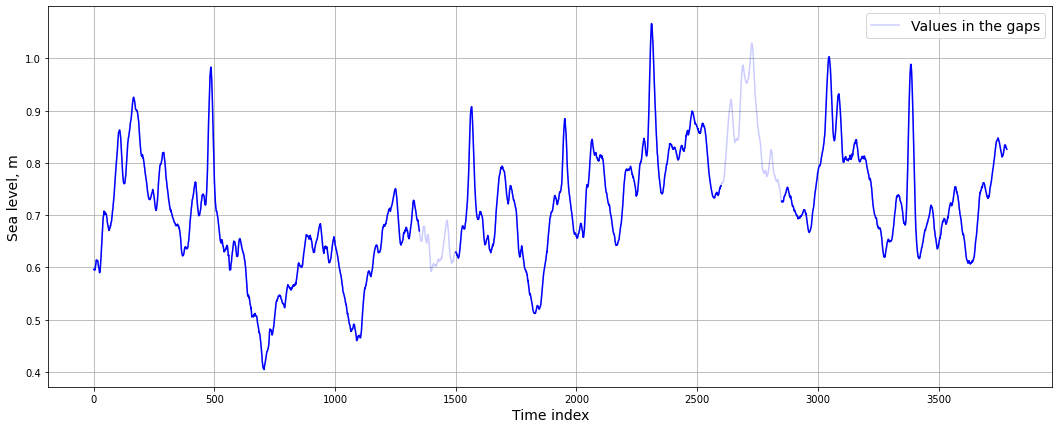

In [10]:
# Make masked array for visualisation
masked_array = np.ma.masked_where(array_with_gaps == -100.0, array_with_gaps)

# Plot time series with gaps
plt.plot(time_series, c='blue', alpha=0.2, label='Values in the gaps')
plt.plot(masked_array, c='blue', alpha=1.0)
plt.ylabel('Sea level, m', fontsize=14)
plt.xlabel('Time index', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

There are two ways to fill in gaps with FEDOT:
* Using simple methods such as linear interpolation or polynomial approximation (SimpleGapFiller);
* Using composite models that FEDOT can build (ModelGapFiller).

We will try to fill in the gaps using different methods and compare the results.

In [11]:
from fedot.utilities.ts_gapfilling import ModelGapFiller, SimpleGapFiller

### Time series gap-filling using simple methods

Simple methods for filling in time series gaps in the FEDOT framework include:
* Linear interpolation
* Local polynomial approximation

<img src="../jupyter_media/time_series/iterative_approximation.gif" width="500"/>


* Batch polynomial approximation

<img src="../jupyter_media/time_series/batch_approximation.gif" width="500"/>


For Local polynomial approximation and Batch polynomial approximation parameters are the degree of the polynomial function (degree) and the number of points adjacent to the gap used to estimate the coefficients (n_neighbors).

In [12]:
# Define SimpleGapFiller object
simple_gapfill = SimpleGapFiller(gap_value=-100.0)

# Local polynomial approximation (Savitzky–Golay filters)
without_gap_poly_1 = simple_gapfill.local_poly_approximation(array_with_gaps, 
                                                             degree=2, 
                                                             n_neighbors=200)

# Batch polynomial approximation
without_gap_poly_2 = simple_gapfill.batch_poly_approximation(array_with_gaps, 
                                                             degree=10, 
                                                             n_neighbors=1000)

# Linear interpolation
without_gap_linear = simple_gapfill.linear_interpolation(array_with_gaps)

Now draw obtained time series.

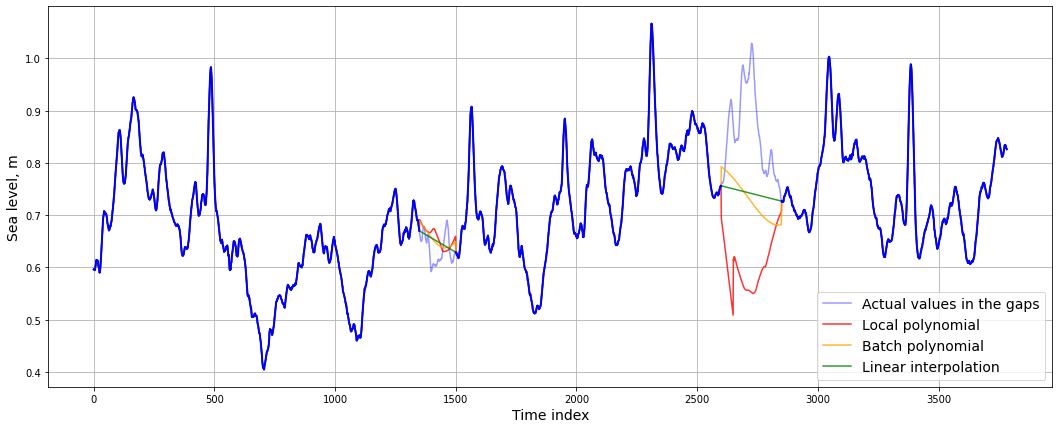

In [13]:
plt.plot(time_series, c='blue', alpha=0.4, label='Actual values in the gaps')
plt.plot(without_gap_poly_1, c='red', alpha=0.8, label='Local polynomial')
plt.plot(without_gap_poly_2, c='orange', alpha=0.8, label='Batch polynomial')
plt.plot(without_gap_linear, c='green', alpha=0.8, label='Linear interpolation')
plt.plot(masked_array, c='blue', alpha=1.0, linewidth=2)
plt.ylabel('Sea level, m', fontsize=14)
plt.xlabel('Time index', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

### Time series gap-filling using pipelines

To fill in the gaps, FEDOT uses the time series forecasting functionality. To fill in the gap, you can use time series forecasting: one forecast for one interval with a gap (forward_filling). It is also possible to use the pre-history and post-history parts of the gap to make forecasts and then to combine the resulting predictions (forward_inverse_filling). The described concept is illustrated by the picture below.

<img src="../jupyter_media/time_series/ts_gapfilling.png" width="600"/>

Scheme of the gap-filling approach based at the a bi-directional forecasting. $t$ - time step-index, $\omega$ - size of the historical time window for forecasting, $f$ - forecast length (less of equal the gap size).

In [14]:
# Function for creating pipeline
def get_simple_ridge_pipeline():
    node_lagged = PrimaryNode('lagged')
    node_lagged.custom_params = {'window_size': 250}

    node_final = SecondaryNode('ridge', nodes_from=[node_lagged])
    pipeline = Pipeline(node_final)

    return pipeline

pipeline = get_simple_ridge_pipeline()
model_gapfiller = ModelGapFiller(gap_value=-100.0,
                                 pipeline=pipeline)

# Filling in the gaps
without_gap_forward = model_gapfiller.forward_filling(array_with_gaps)
without_gap_bidirect = model_gapfiller.forward_inverse_filling(array_with_gaps)

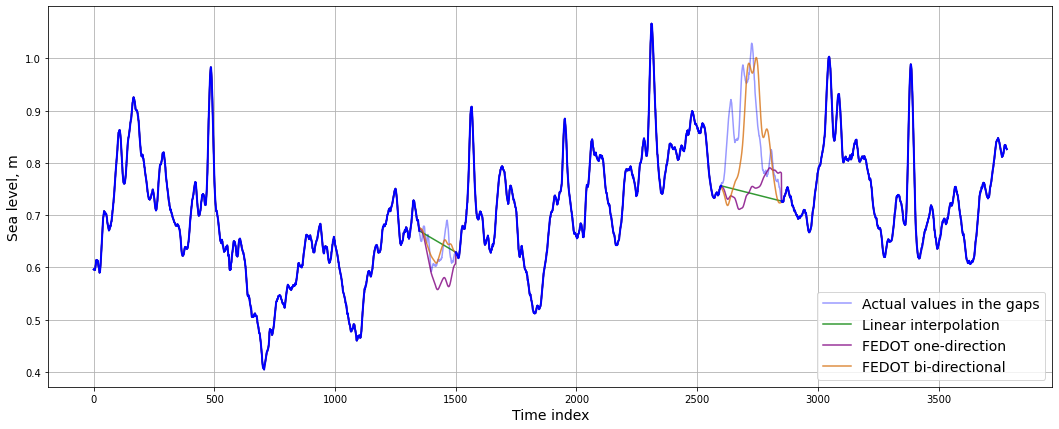

In [15]:
plt.plot(time_series, c='blue', alpha=0.4, label='Actual values in the gaps')
plt.plot(without_gap_linear, c='green', alpha=0.8, label='Linear interpolation')
plt.plot(without_gap_forward, c='purple', alpha=0.8, label='FEDOT one-direction')
plt.plot(without_gap_bidirect, c='#D77214', alpha=0.8, label='FEDOT bi-directional')
plt.plot(masked_array, c='blue', alpha=1.0, linewidth=2)
plt.ylabel('Sea level, m', fontsize=14)
plt.xlabel('Time index', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

Thus, we can see that the gaps in the time series were filled more accurately when using bi-directional forecast with FEDOT pipelines. 

So, we learned how to predict the time series for many values ahead (out-of-sample forecasting), and also use the FEDOT functionality to fill in the gaps in the time series.